# Bonus-track Assignment 2: Custom Python implementation

Implement the Echo State Network as a custom TensorFlow/Keras or PyTorch model. Pay attention to the efficiency of the implementation (e.g., you don’t need to re-calculate the states you have already computed). Consider the possibility of using scikit-learn models for the readout. Solve the previous (and following) problems with the custom python code obtained in this way.

## Libraries

In [1]:
import torch
from torch import Tensor, vstack

import pandas as pd
from sklearn.linear_model import SGDRegressor

# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Utils/utils.py
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_2/Assignment2/PytorchESN_base.py

from Utils.utils import make_sequence, show_result
from LAB3_2.Assignment3.PytorchESN_base import LatentESN

## Sklearn Readout

In [2]:
class SGD_Seq2Seq(LatentESN):
    def __init__(self, input_size: int, hidden_dim: int, omega: float,
                 spectral_radius: float, max_iter:int):

        super().__init__(input_size, hidden_dim, omega, spectral_radius)
        self.classifier = SGDRegressor(max_iter=max_iter, learning_rate="adaptive")

    def fit(self, x:Tensor, y:Tensor, transient:int):

        h_stack = self.reservoir(seq=x)
        h_stack, y = h_stack[transient:], y[transient:].squeeze()

        self.classifier.fit(h_stack, y)

    def validate(self, x:Tensor, y:Tensor, h0:Tensor=None):

        h_stack = self.reservoir(seq=x, h0=h0)
        y_pred = self.classifier.predict(h_stack)

        loss = None
        if y is not None:
            loss = self.MSE(y, y_pred)

        output = h_stack[-1], y_pred
        return ((loss,) + output) if loss is not None else output

    @staticmethod
    def MSE(y: Tensor, y_pred: Tensor) -> float:
        """
        Mean square error
        :param y: Target
        :param y_pred: Predicted target
        """
        return torch.pow((y - y_pred), 2).mean()

## Retrieve the datasets

In [3]:
# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/NARMA10.csv
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/MG17.csv
source1 = pd.read_csv("./../../Sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("./../../Sources/MG17.csv", header=None).T.to_numpy()

## NARMA10

In [4]:
tr_dataset = make_sequence(source1[:4000], 1, "NARMA10")
dev_dataset = make_sequence(source1[4000:5000], 1, "NARMA10")
ts_dataset = make_sequence(source1[5000:], 1, "NARMA10")

K:\NoSyncProject\Computational-NeuroScience-Lab\LAB3_2\Assignment2\PytorchESN_base.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  z = self.Wx @ x.T + self.Wh @ h_stack[i - 1].T + self.bh  # [steps, hidden_size]


Train Error 0.010812
Test Error 0.010536


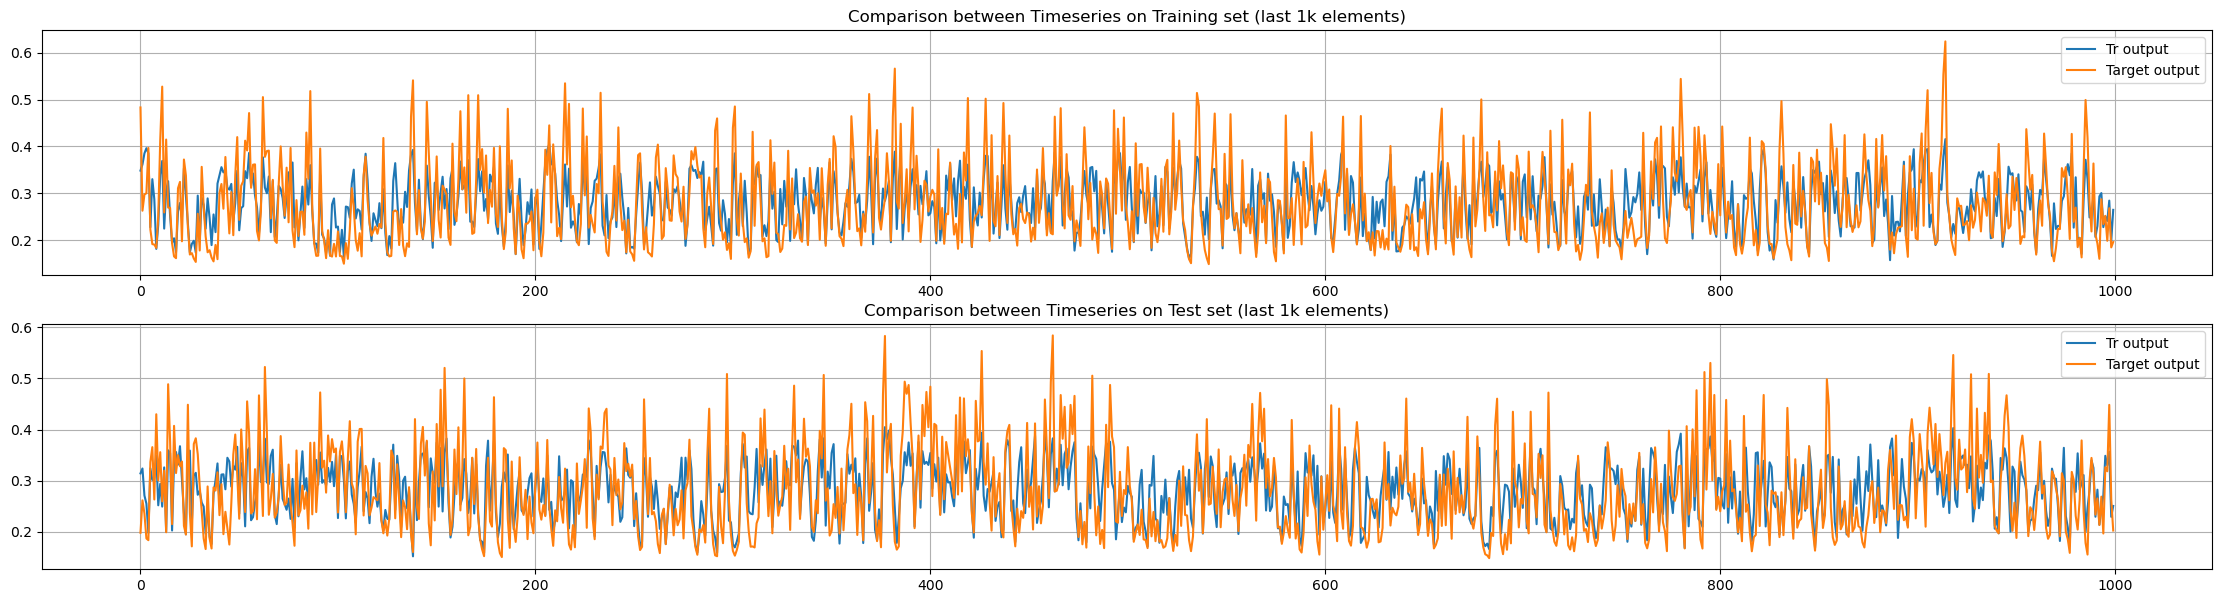

In [5]:
regressor = SGD_Seq2Seq(1, 150, 0.5, 0.9, 10000)
regressor.fit(*tr_dataset, transient=100)

tr_dataset = tuple(vstack((x, y)) for x, y in zip(tr_dataset, dev_dataset))
tr_loss, h_last, tr_pred = regressor.validate(*tr_dataset)
print("Train Error", round(tr_loss.item(), 6))

ts_loss, _, ts_pred = regressor.validate(*ts_dataset, h_last)
print("Test Error", round(ts_loss.item(), 6))

show_result(tr_pred, tr_dataset[1], ts_pred, ts_dataset[1])

## Mackey-Glass 17

In [6]:
tr_dataset = make_sequence(source2[:4000], 1, "MG17")
dev_dataset = make_sequence(source2[4000:5000], 1, "MG17")
ts_dataset = make_sequence(source2[5000:], 1, "MG17")

Train Error 0.093681
Test Error 0.093051


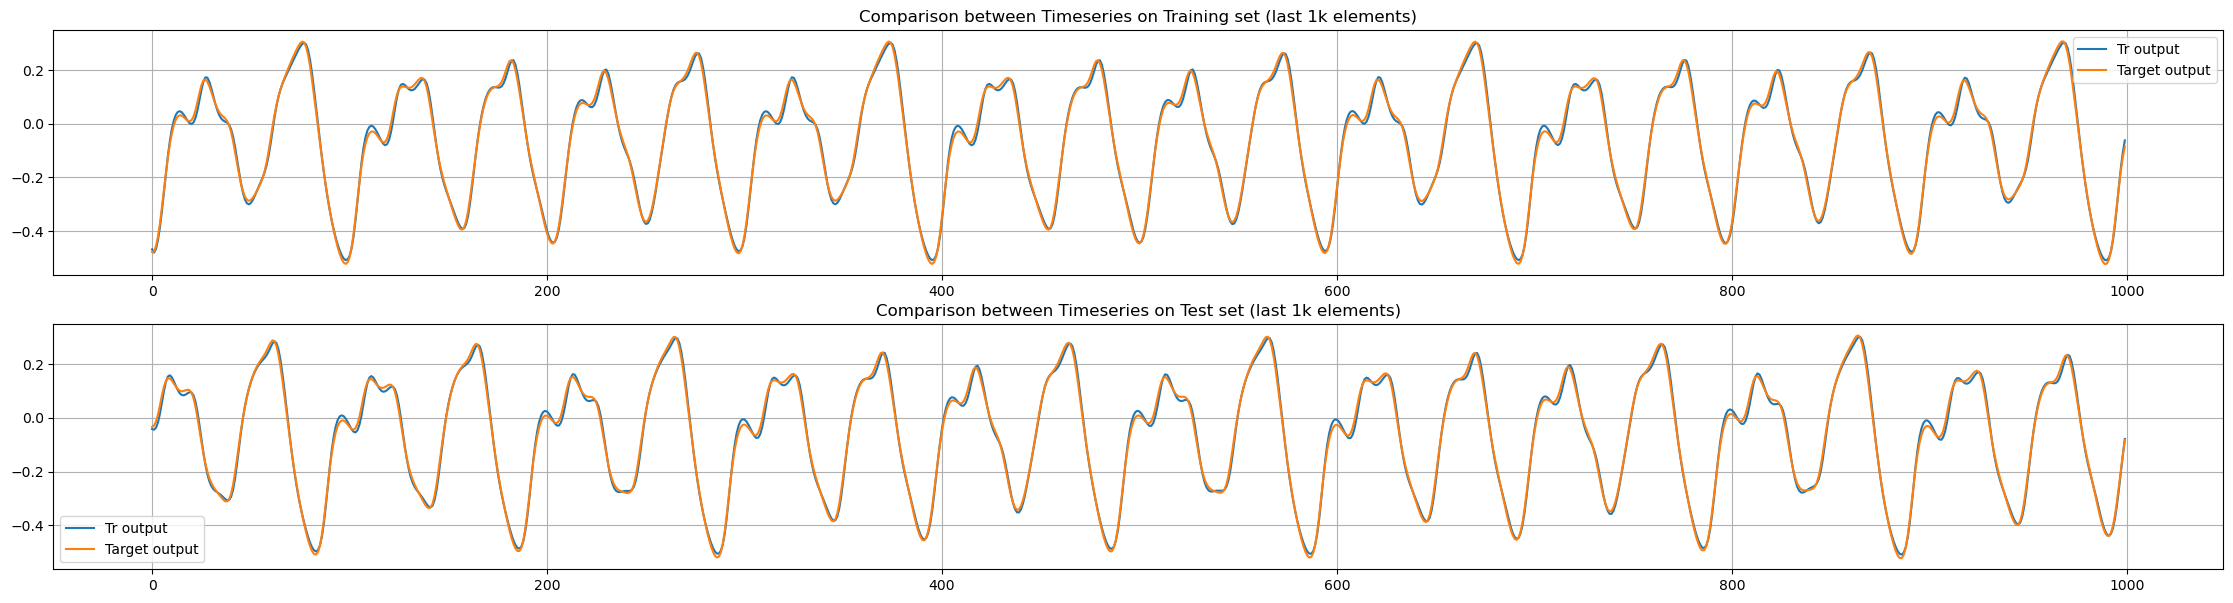

In [7]:
regressor = SGD_Seq2Seq(1, 150, 0.5, 0.9, 10000)
regressor.fit(*tr_dataset, transient=100)

tr_dataset = tuple(vstack((x, y)) for x, y in zip(tr_dataset, dev_dataset))
tr_loss, h_last, tr_pred = regressor.validate(*tr_dataset)
print("Train Error", round(tr_loss.item(), 6))

ts_loss, _, ts_pred = regressor.validate(*ts_dataset, h_last)
print("Test Error", round(ts_loss.item(), 6))

show_result(tr_pred, tr_dataset[1], ts_pred, ts_dataset[1])